# Notebook to plot power spectra and CF for the halos and cdm

## Loading packages

In [1]:
import numpy as np
# import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 16).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from sympy import symbols, Eq, solve



## Nested dictionary

In [12]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(7, list)
pow_gev = nested_dict(2, list)
class_data = nested_dict(3, list)
rsd_coeff = nested_dict(2, list)
bias_halo = nested_dict(2, list)
bias_halo_lin = nested_dict(2, list)
rsd_coeff_halo = nested_dict(2, list)
f_gr_data =nested_dict(2, list)

## Weighted power log, linear and every N point

In [3]:
def wighted_power(k_w, Pk, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip, string):
    if (string=="log"):
        print("method:",string)
        du  = (np.log10(kmax)-np.log10(kmin) )/number_binning;
        weight_pow=np.zeros((number_binning,3));
        k = kmin;
        for i in range(number_binning):
            k = k * 10** (du);
            dk = k * (10** (du) -1.0);
            for j in range (np.int(np.shape(k_w)[0])):
                if(k_w[j]>k-dk/2. and k_w[j]<k+dk/2. and k_w[j]<(k_w.max())/nyqvist_skip and j> 1*cosmicvar_skip ):
                    weight_pow[i,0] = weight_pow[i,0] + k_w[j] * count_arr[j]; # To correct the k based on the weights
                    weight_pow[i,1] = weight_pow[i,1] + Pk[j] * count_arr[j];
                    weight_pow[i,2] = weight_pow[i,2] + count_arr[j];

            if (weight_pow[i,1] !=0):
                weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,2]
                weight_pow[i,1] =weight_pow[i,1]/weight_pow[i,2];
            else:
                weight_pow[i,1] =weight_pow[i,1];
    if (string=="lin"):
        print("method:",string)
        dk  = (kmax-kmin)/number_binning;
        weight_pow=np.zeros((number_binning,3));
        k = kmin;
        for i in range(number_binning):
            k = k + dk;
            for j in range (np.int(np.shape(k_w)[0])):
                if(k_w[j]>k-dk/2. and k_w[j]<k+dk/2. and k_w[j]<(k_w.max())/nyqvist_skip and j> 1*cosmicvar_skip ):
                    weight_pow[i,0] = weight_pow[i,0] + k_w[j] * count_arr[j]; # To correct the k based on the weights
                    weight_pow[i,1] = weight_pow[i,1] + Pk[j] * count_arr[j];# To correct the Pk based on the weights
                    weight_pow[i,2] = weight_pow[i,2] + count_arr[j];

            if (weight_pow[i,1] !=0):
                weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,2]
                weight_pow[i,1] = weight_pow[i,1]/weight_pow[i,2];
            else:
                weight_pow[i,1] =weight_pow[i,1];
                
    if (string=="every_N_point"):
        # number_binning is actually how many points to collect
        print("method:",string)
        number_modes  = np.int(np.shape(k_w)[0]/number_binning);
        weight_pow=np.zeros((number_modes,5));
        
        for i in range(number_modes):
            for j in range (number_binning):
                weight_pow[i,0] = weight_pow[i,0] + k_w[i*number_binning+j]* count_arr[i*number_binning+j]; # To correct the k based on the weights
                weight_pow[i,1] = weight_pow[i,1] + Pk[i*number_binning+j] * count_arr[i*number_binning+j];# To correct the Pk based on the weights
                weight_pow[i,4] = weight_pow[i,4] + count_arr[i*number_binning+j];                 
            weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,4] #mean of k
            weight_pow[i,1] = weight_pow[i,1]/weight_pow[i,4];# mean of P
            for j in range (number_binning):
                #S^2 =  \frac{\Sigma_i N_i (P_i - \bar{P})^2}{\Sigma_i N_i -1}
                weight_pow[i,2] = weight_pow[i,2] + (count_arr[i*number_binning+j]/(weight_pow[i,4]-1)) * (k_w[i*number_binning+j] - weight_pow[i,0])**2
                weight_pow[i,3] = weight_pow[i,3] + (count_arr[i*number_binning+j]/(weight_pow[i,4]-1)) * (Pk[i*number_binning+j] - weight_pow[i,1])**2
    return weight_pow



# Loading power and CF data

In [16]:
# directory = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Powerpsectra_correlationfunction_particles_Pylians/"
# directory_halo = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Power_spectra_correlation_function_RSD_noRSD_Halos/"
# directory_power = "/Users/farbod/Dropbox/Projects/Doppler_RSD//Data/kevolution_gevolution_power_output/"
# directory_jackknife = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/AutoCorrelation_Halos_Jackknife//"
directory_cross = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Resolution_method_test_19July2021///"

files=["gevolution_boxsize_4032_ngrid_4608_lcdm_05062020"];

redshifts = ["0"];
files_list = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
#############    
### Pylians #
#############
for k in range (4): #method
    for j in range(1): # file
        for i in range(1): # redshift
            if (j==0):
                data['cross']['2500'][method[k]]['RSD'][files_list[j]]['pow']['z='+redshifts[i]]=load(directory_cross+"/Method_test_lcdm/cross_pk3D_"+method[k]+"_Ngrid_2500_"+files[j]+"_z_"+str(redshifts[i])+".npy");
                data['cross'][Ngrid[k]]['TSC']['RSD'][files_list[j]]['pow']['z='+redshifts[i]]=load(directory_cross+"/resolution_test//cross_pk3D_TSC_Ngrid_"+Ngrid[k]+"_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#                 data['cross']['2500'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_cross+"/RSD/Cross_powerspectra_wcdm//cross_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");


## Tests

In [20]:
data.keys()
data.keys()
data['cross'].keys()
data['cross']['2500'].keys()
data['cross']['2500']['CIC'].keys()

dict_keys(['RSD'])

# Mass assignment method (NGP, CIC, TSC ..) on moments

## monopole, halos/cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


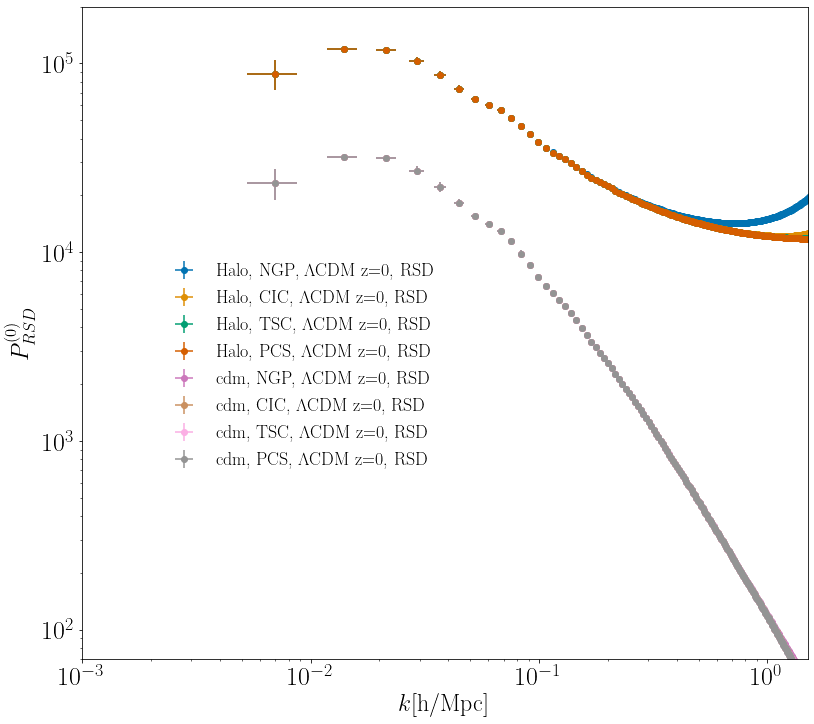

In [89]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(0)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.45], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


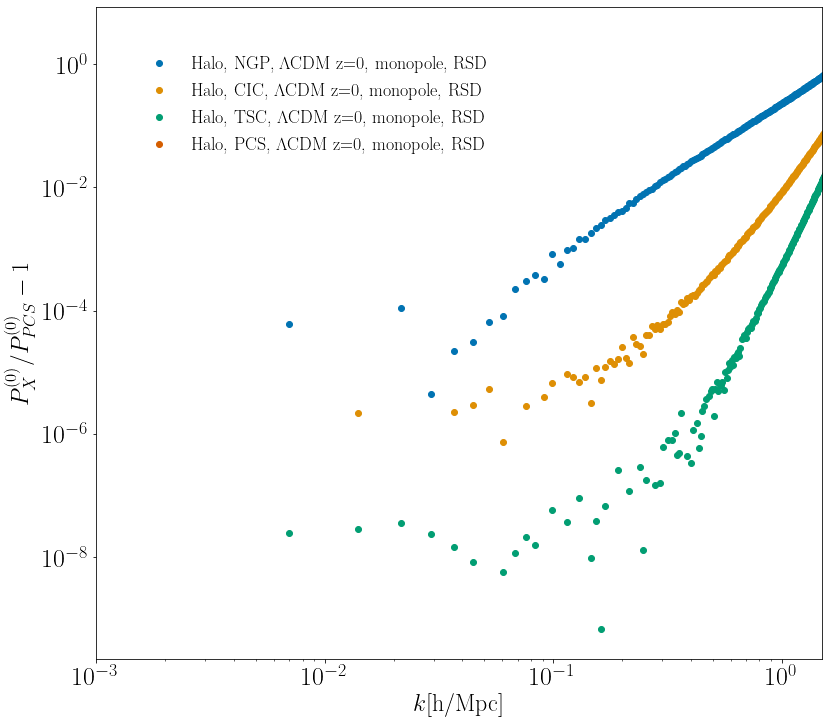

In [70]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


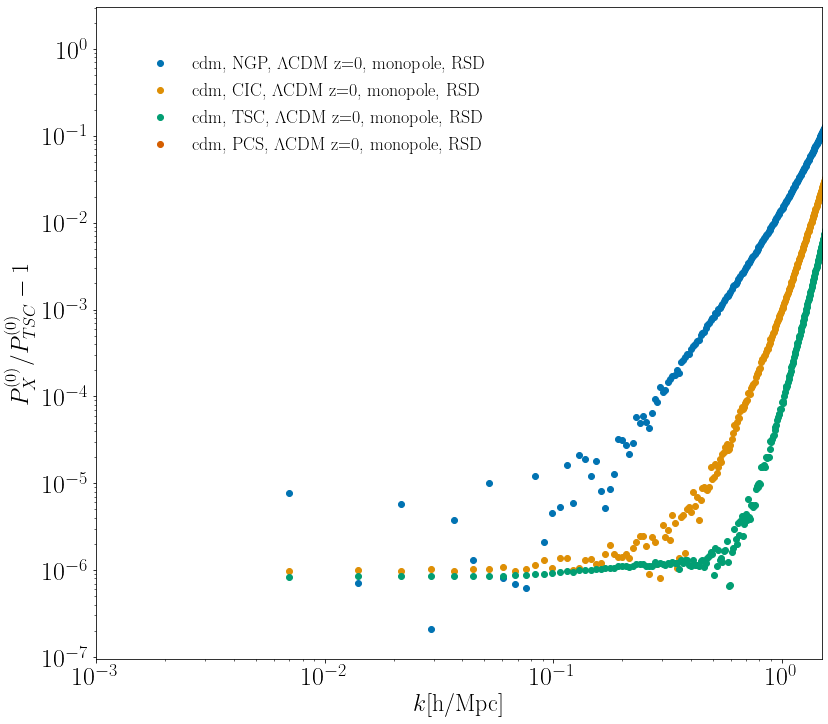

In [71]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], np.abs(weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{TSC} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


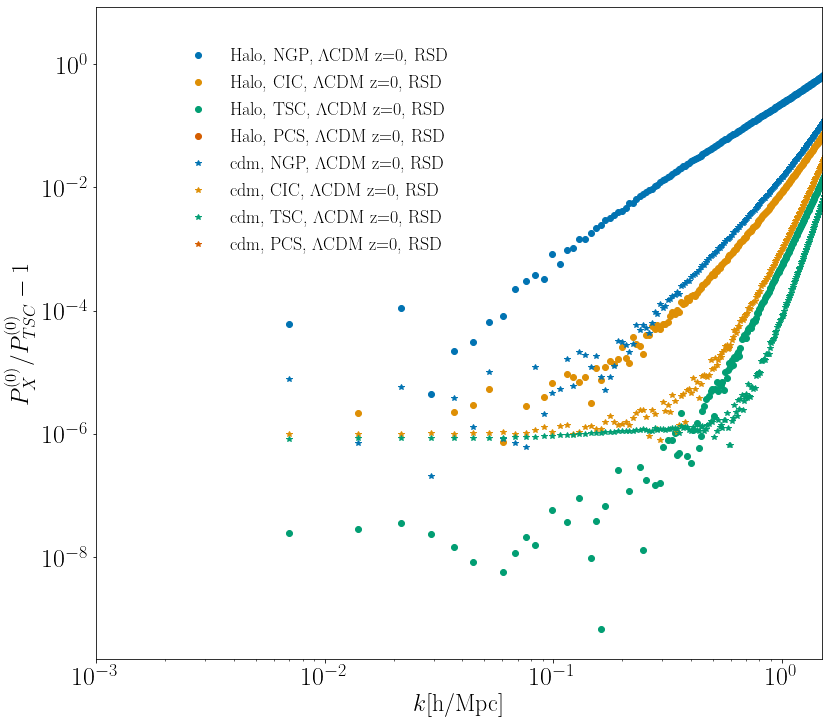

In [150]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], np.abs(weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'*', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{TSC} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.78], loc='center',frameon=False)
X=np.arange(0.001,20,1)



## quadrupole halos/cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


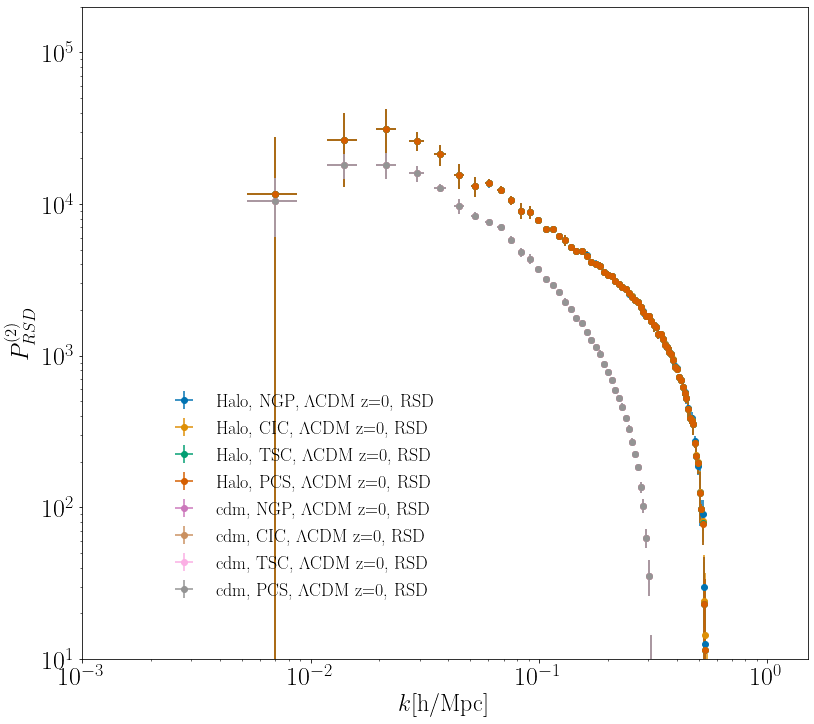

In [95]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(2)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.25], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


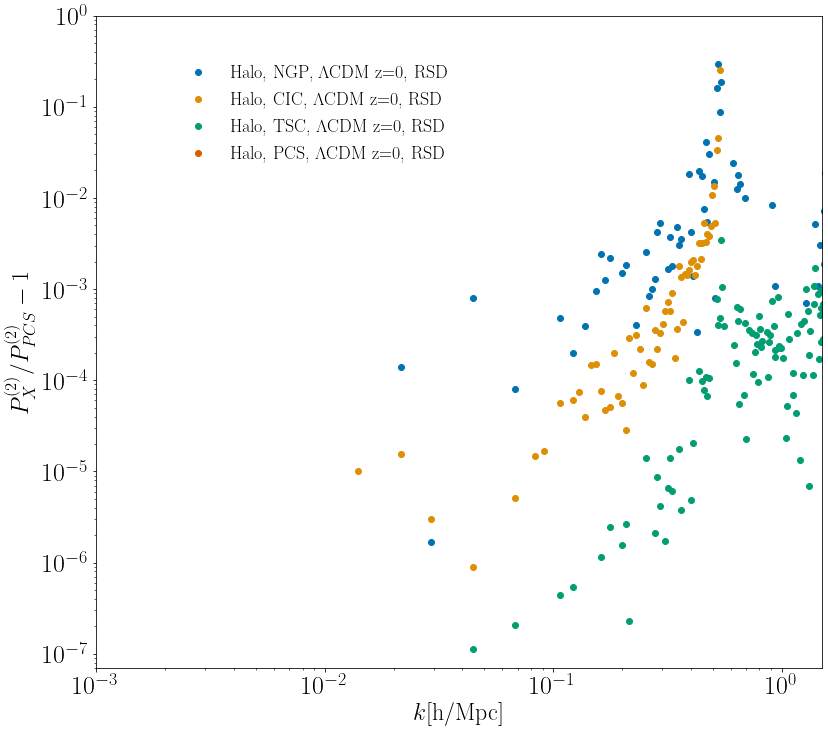

In [91]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


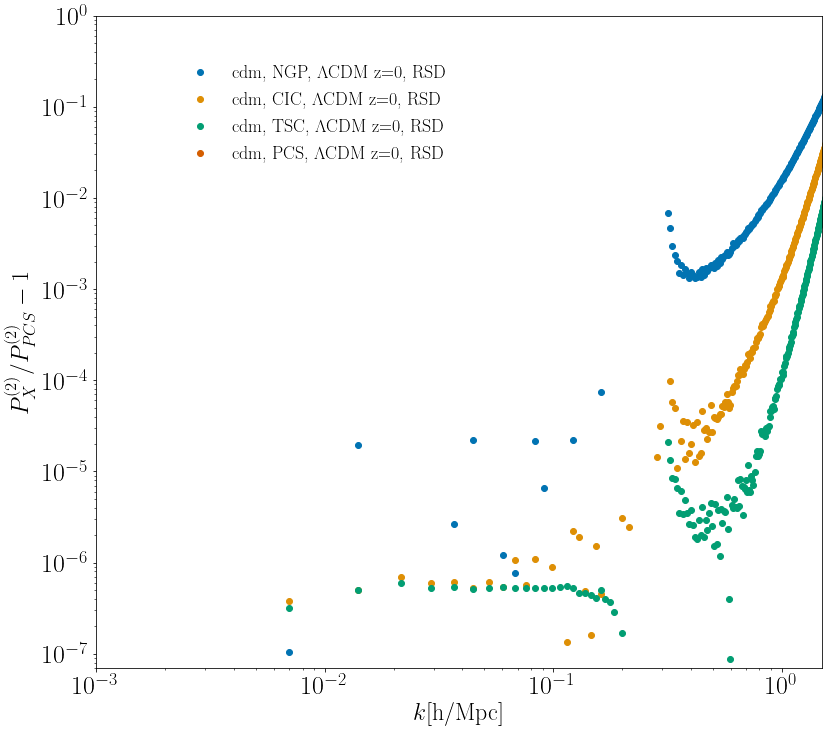

In [92]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Realtive difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


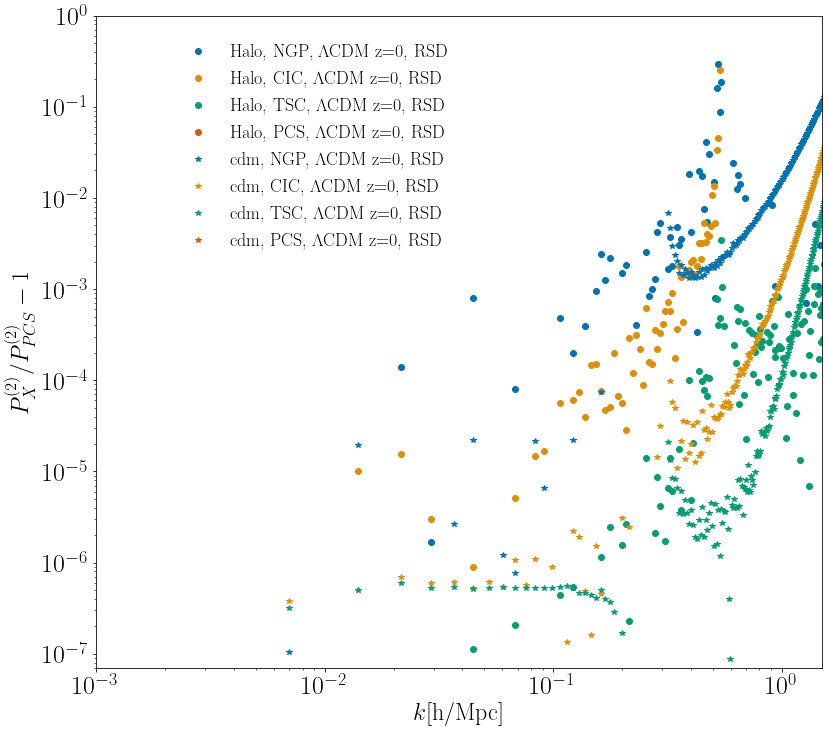

In [148]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'*', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.8], loc='center',frameon=False)
X=np.arange(0.001,20,1)



## Hexadecapole halos/cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


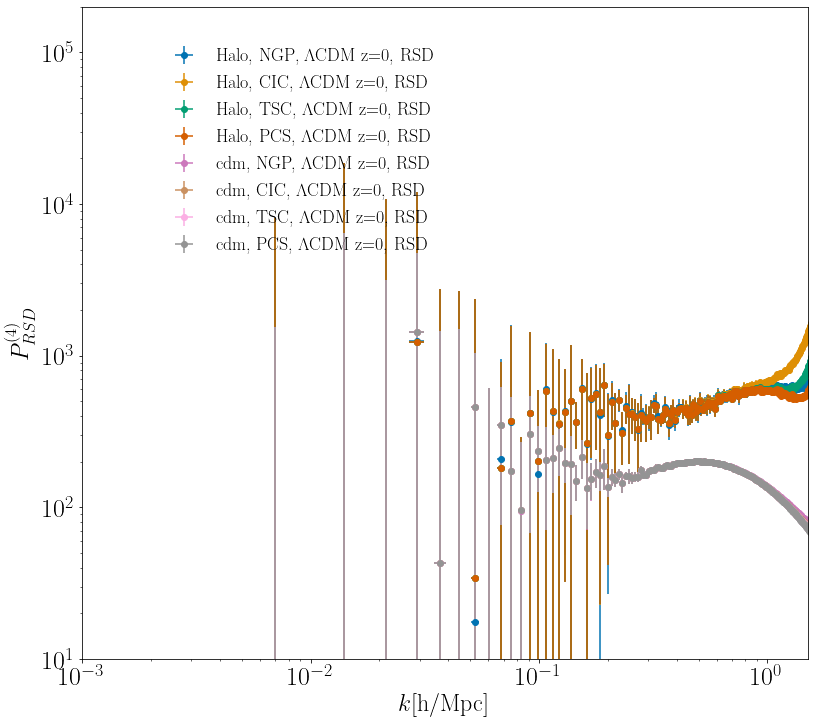

In [93]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(4)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.78], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


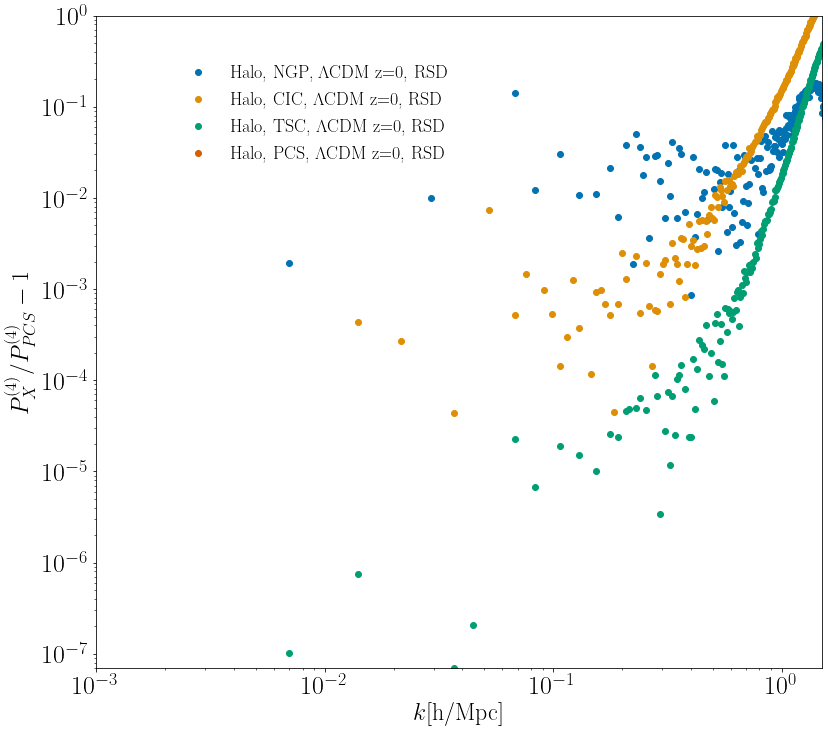

In [96]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


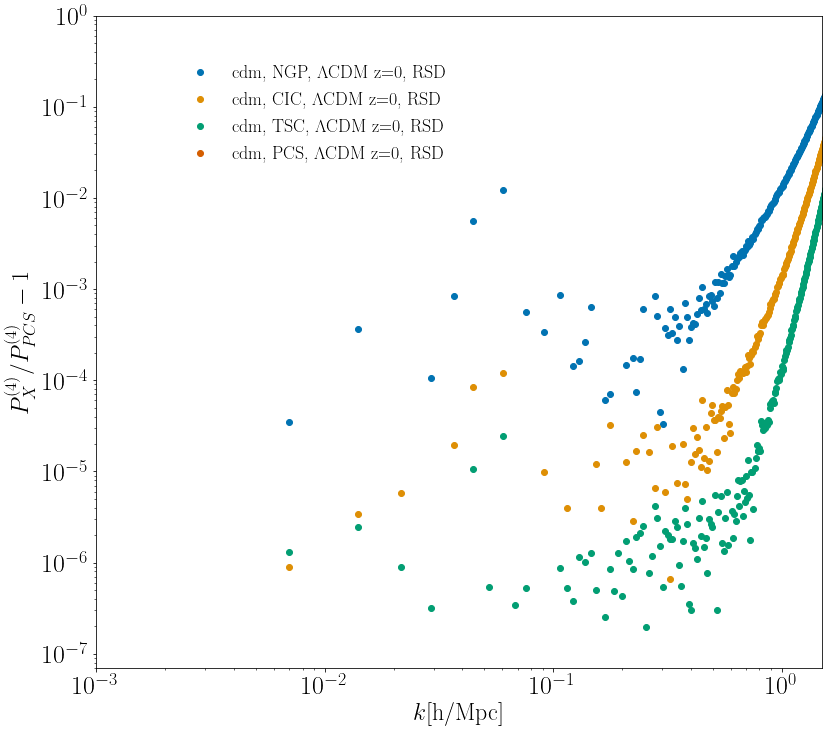

In [97]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


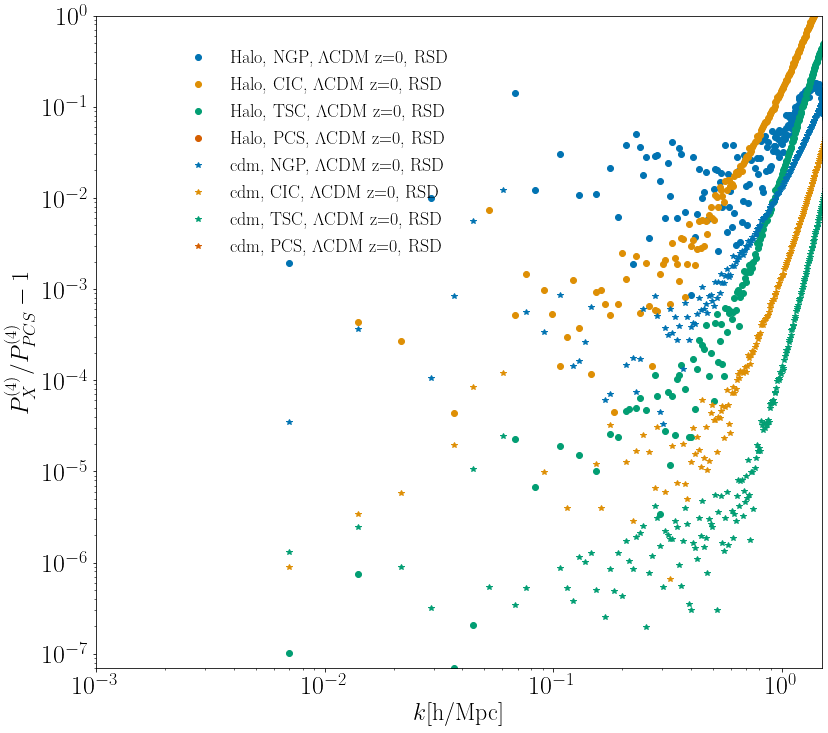

In [146]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'o', color =Colors[l], label="Halo, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for n_method in range (4): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind]['2500'][method[n_method]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        
        # Ref
        count_arr = data[kind]['2500'][method[3]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        plt.plot(weighted_arr_ref[:,0], (weighted_arr[:,1]-weighted_arr_ref[:,1])/weighted_arr_ref[:,1],'*', color =Colors[l], label="cdm, "+method[n_method]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{PCS} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-8,1)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.79], loc='center',frameon=False)
X=np.arange(0.001,20,1)



# Resolution effect

## monopole halos/cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


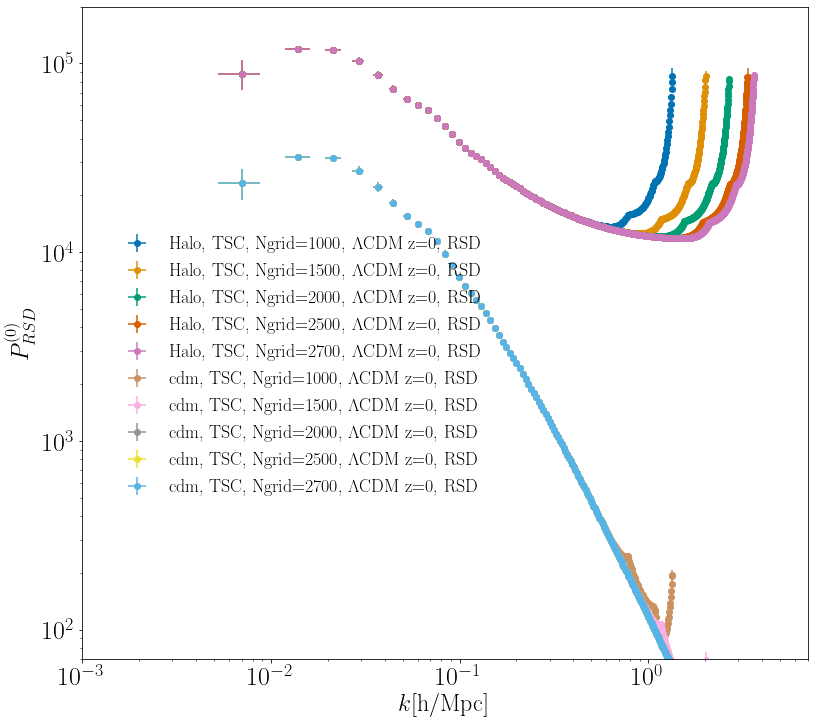

In [110]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(0)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,7)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.45], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


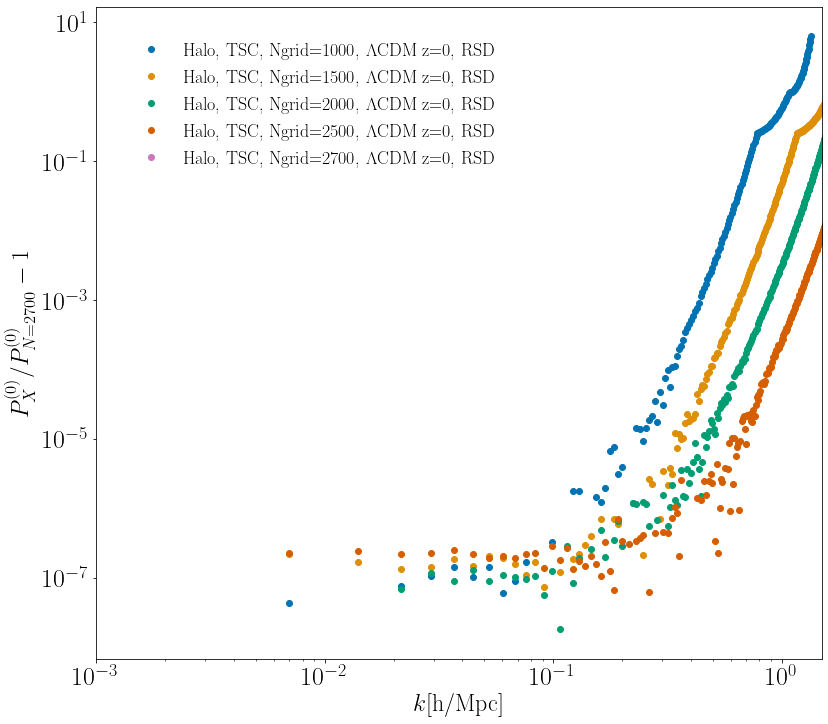

In [112]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


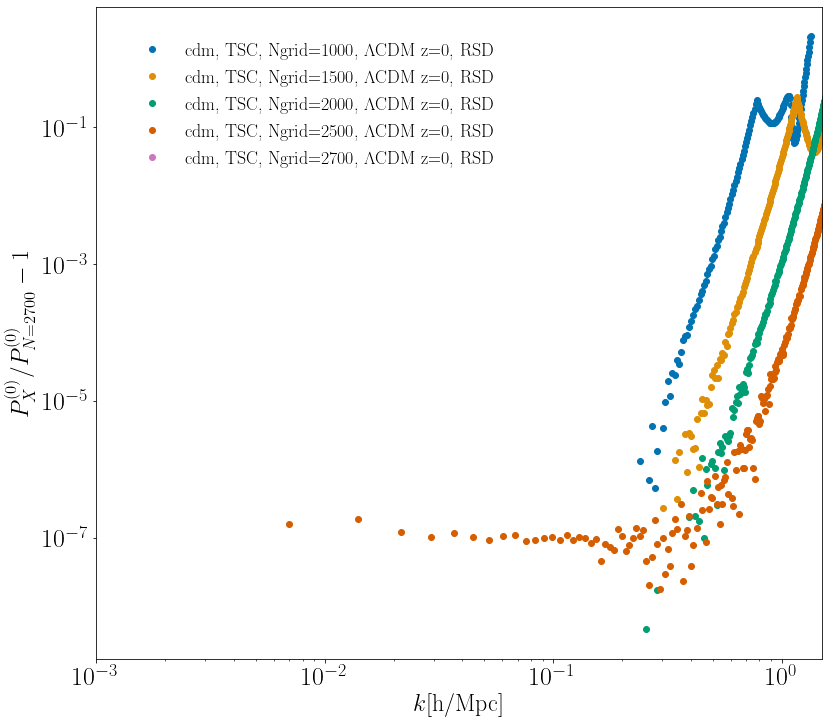

In [113]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


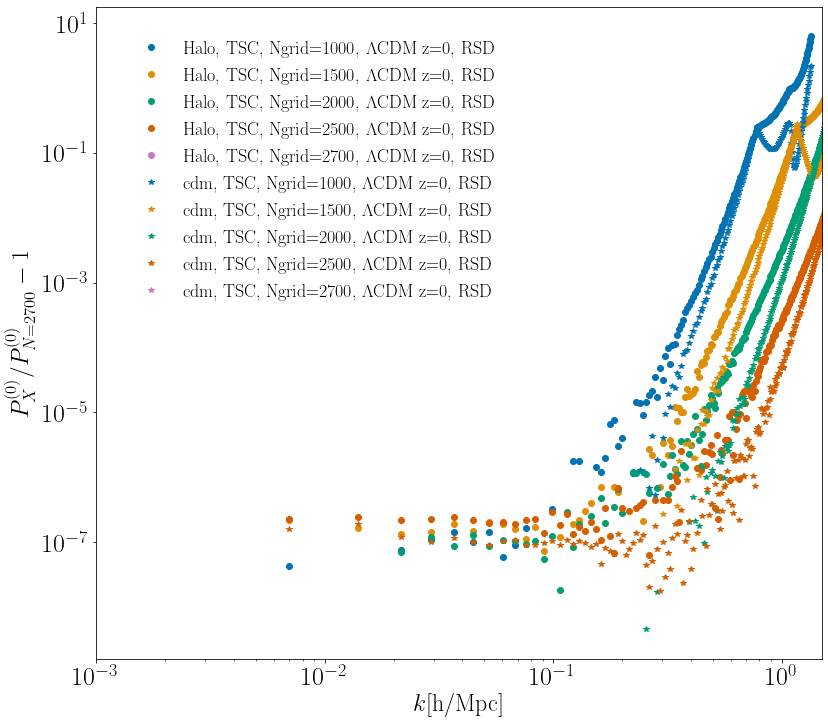

In [142]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)

# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk0_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'*', color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(0)}_{X}/P^{(0)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.75], loc='center',frameon=False)
X=np.arange(0.001,20,1)


## quadrupole cdm/halos:

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


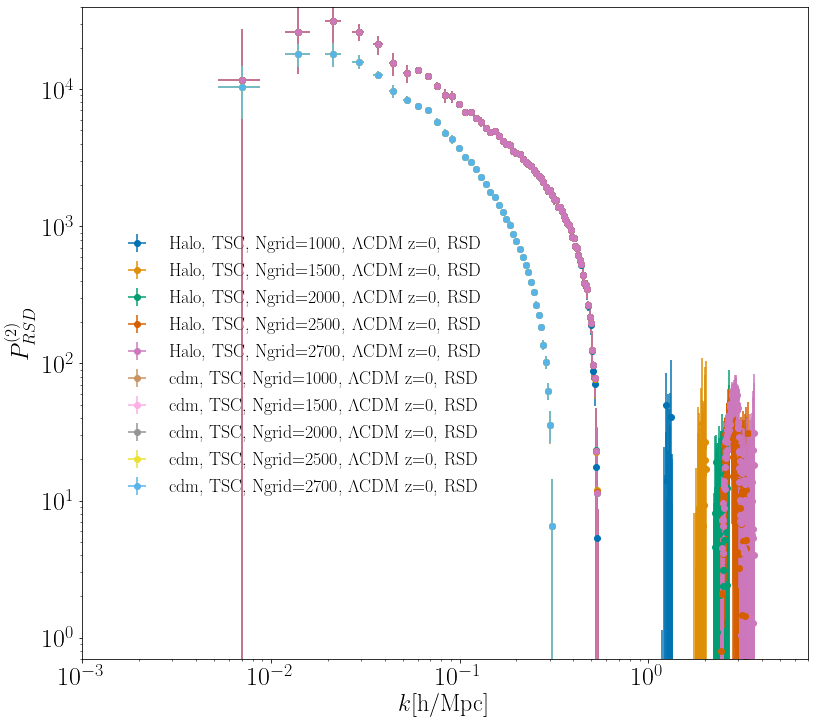

In [116]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(2)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-1,4.e4)
axs.set_xlim(1.e-3,7)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.45], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos:

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


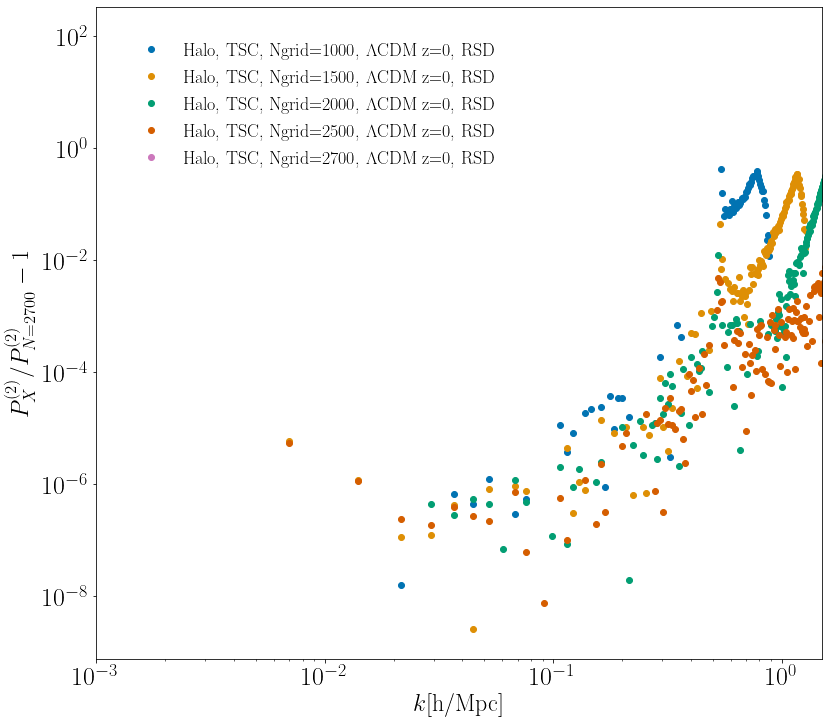

In [125]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm:

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


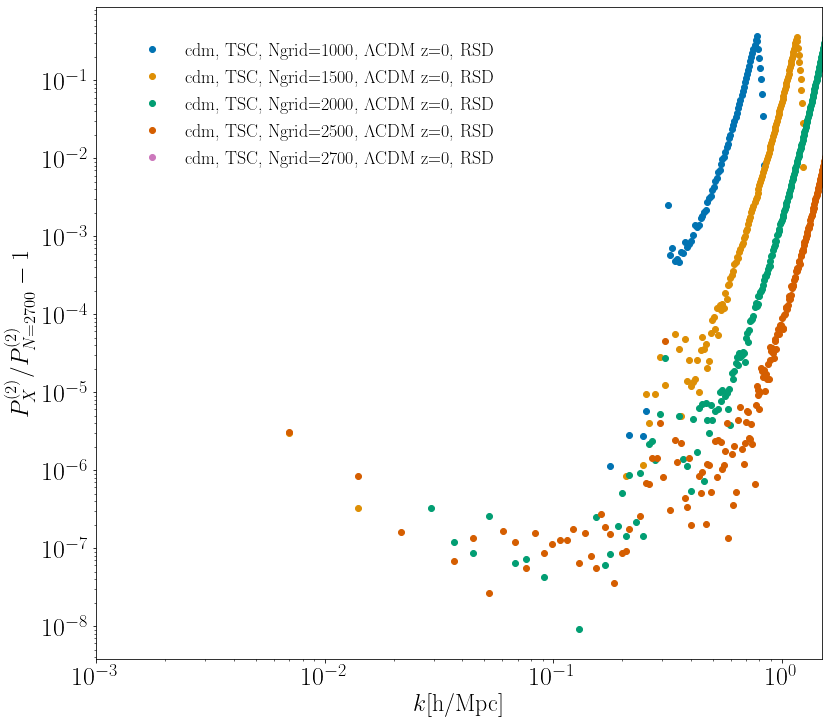

In [123]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


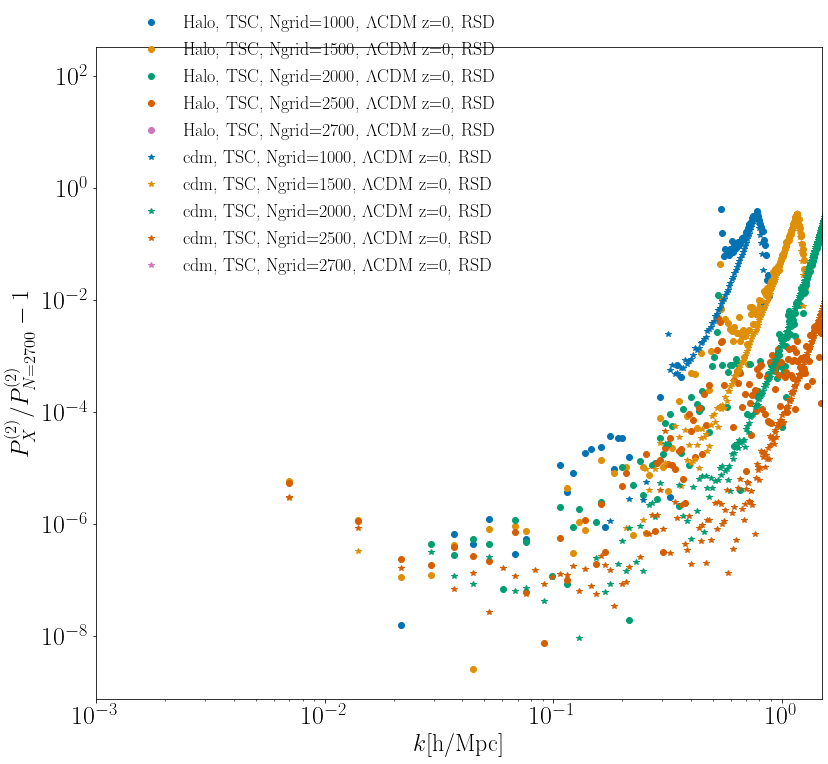

In [139]:


plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk2_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'*', color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(2)}_{X}/P^{(2)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


## Hexadecapole

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


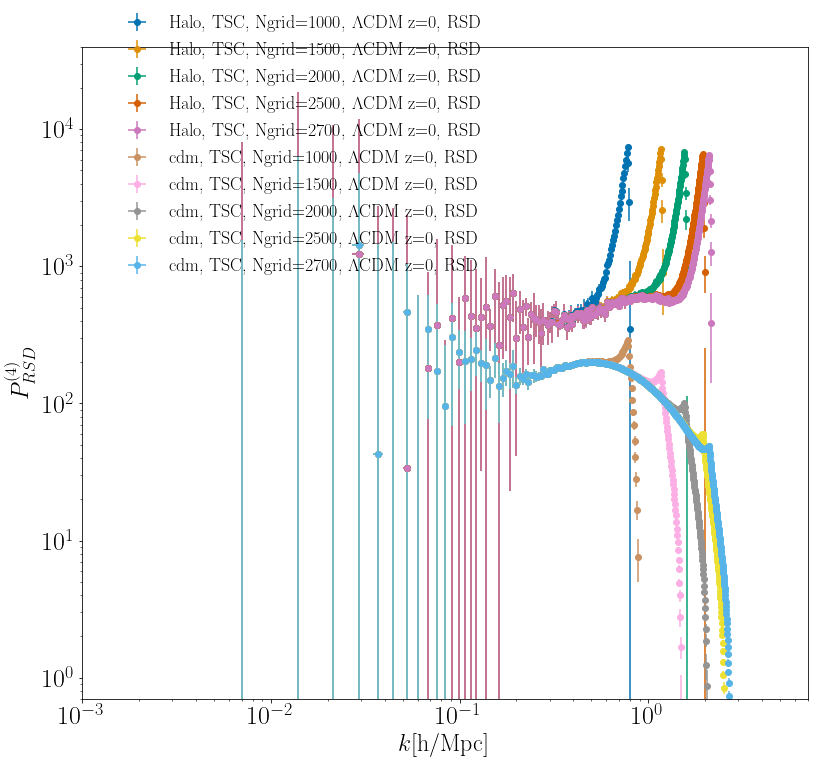

In [122]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

        
for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1

    
axs.set_ylabel(r'$P^{(4)}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(7.e-1,4.e4)
axs.set_xlim(1.e-3,7)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference halos:

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


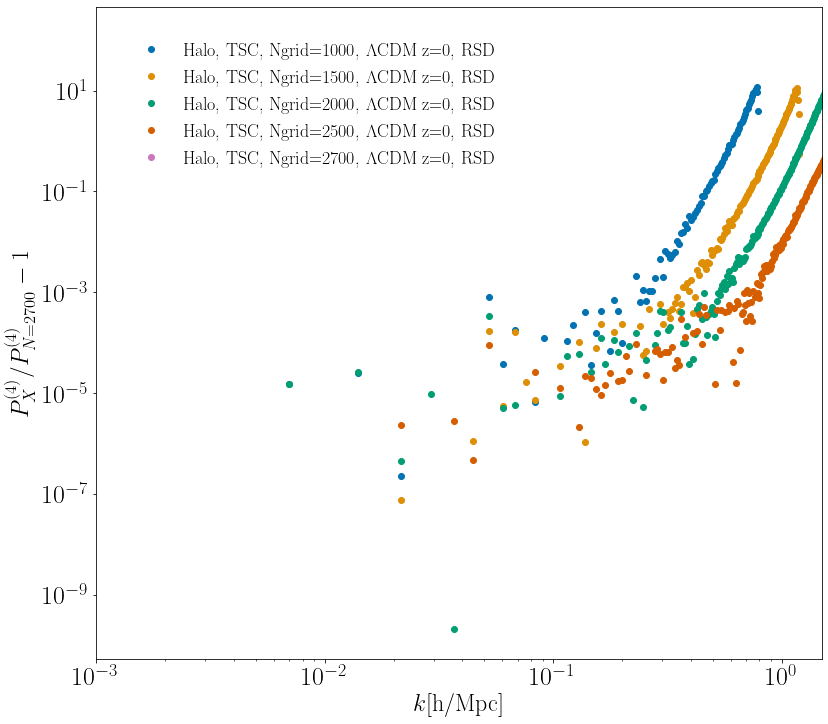

In [121]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Relative difference cdm:

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


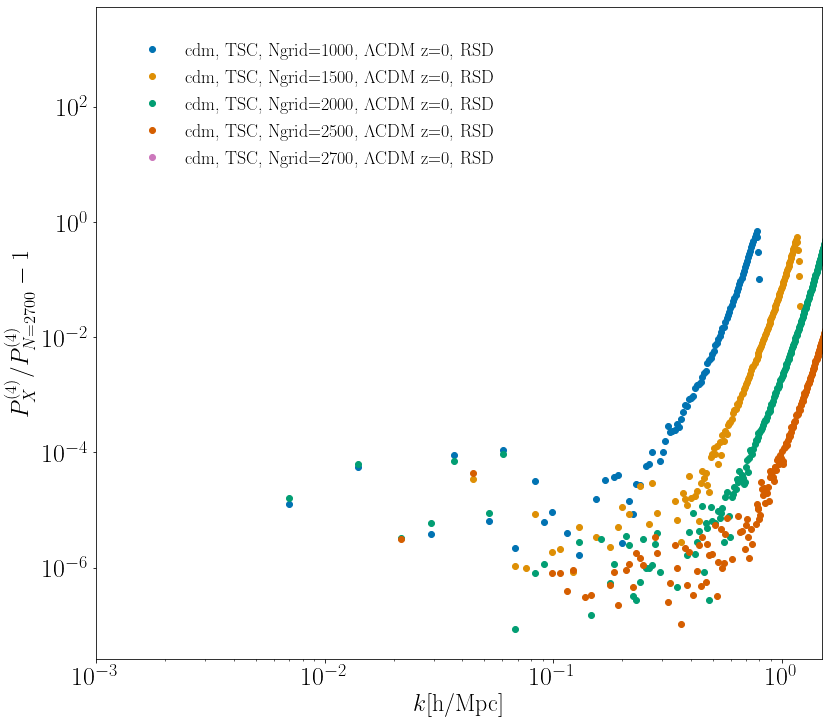

In [124]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Realtive difference all

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


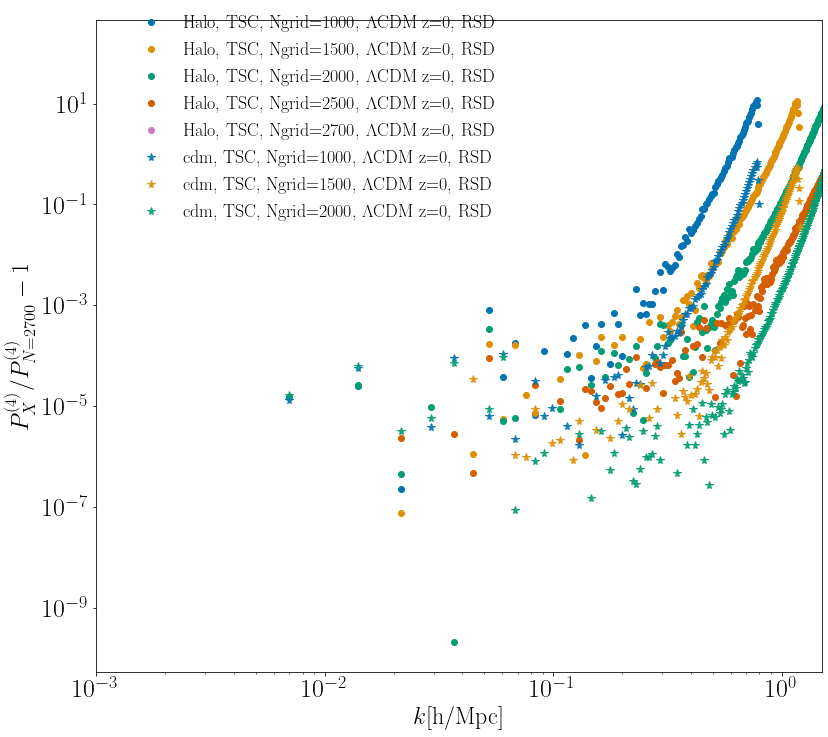

In [136]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (5): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'o', color =Colors[l], label="Halo, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    

# RSD ='noRSD'
redshifts = ["0"];
file = ['gev_lcdm'];
method = ['NGP','CIC','TSC','PCS'];
Ngrid = ['1000','1500','2000','2500','2700'];
l=0

kind = "cross"
RSD ='RSD'
l=0
# Halos

for i in range (3): # file 1
        num1=0
        redshift ="z="+redshifts[0];
        
        [k0_ref,pk0_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2_ref,pk2_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4_ref,pk4_ref]=data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos

        
        [k0,pk0]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,2],:] # monopole of halos
        [k2,pk2]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,4],:] # quadrupole of halos
        [k4,pk4]=data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][[0,6],:] # hexadecapole of halos
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
#         Averaging weighted based on the # of modes
        count_arr = data[kind][Ngrid[i]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        
        
        # Ref
        count_arr = data[kind][Ngrid[4]][method[2]][RSD][file[num1]]['pow'][redshift][10,:]
        number_binning = 50;
        kmin = k0_ref.min();
        kmax = k0_ref.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =5
        
        weighted_arr_ref = wighted_power(k0_ref, pk4_ref, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        interp_pk = interpolate.interp1d(weighted_arr_ref[:,0], weighted_arr_ref[:,1])
        k = weighted_arr[:,0]
        plt.plot(k, (weighted_arr[:,1]-interp_pk(k))/interp_pk(k),'*',markersize=8,alpha=0.9, color =Colors[l], label="cdm, TSC, Ngrid="+Ngrid[i]+r", $\Lambda$CDM "+redshift+", "+RSD)
        l= l +1


    
axs.set_ylabel(r'$P^{(4)}_{X}/P^{(4)}_{N=2700} - 1$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
# axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.3, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)
